In [1]:
import pickle
import numpy as np
with open('structured_abstract_sections.pkl', 'rb') as f:
    normalized_sections = pickle.load(f)

sentences = []
indices = []
for normal_sect in normalized_sections:
    print(f'{normal_sect}: {len(normalized_sections[normal_sect])}')
    index = [len(sentences)]
    sentences += [text.lower() for text in normalized_sections[normal_sect]]
    index.append(len(sentences))
    indices.append(index)
    
labels = np.zeros(indices[-1][1], dtype=int)  # 創建一個與最大索引一致的 0 陣列

# 根據 indices 填充標籤
for i, (start, end) in enumerate(indices):
    labels[start:end] = i


methods: 1492
background: 215
results: 314
conclusions: 488
objective: 523


In [2]:
import torch
import numpy as np
import random

# 設置隨機種子
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 確保所有 GPU 也使用相同種子
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # 避免非確定性算法

seed = 42
seed_everything(seed)

In [3]:
# embeddings.shape

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np



# 1. 定義 PyTorch Dataset，先 shuffle 再存入
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        embeddings = np.array(embeddings, dtype=np.float32)
        labels = np.array(labels, dtype=np.longlong)

        # # 先隨機打亂索引
        # indices = np.arange(len(labels))
        # np.random.shuffle(indices)

        # 根據打亂的索引重新排列 embeddings 和 labels
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [5]:
# 2. 定義分類模型
class Classifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 128)  # 隱藏層 128 維
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)  # 輸出層
        self.softmax = nn.LogSoftmax(dim=1)  # 可改用 CrossEntropyLoss 不需明確 softmax

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # CrossEntropyLoss 會處理 softmax，所以這裡不需 softmax

In [6]:
# 3. 創建 Dataset & DataLoader
from tqdm import tqdm
def train_model(train_loader, model, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        print(f'epoch {epoch}:')
        total_loss = 0
        for batch_embeddings, batch_labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(batch_embeddings)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

    return model

In [7]:
mapping = {
    -1: 'None',
    0:'methods',
    1:'background',
    2:'results',
    3:'conclusions',
    4:'objective',
}

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

def evaluate_model(test_loader, model, num_classes, threshold=0.5, average='weighted'):
    model.eval()
    all_embeddings = []
    all_labels = []
    
    for batch_embeddings, batch_labels in test_loader:
        all_embeddings.append(batch_embeddings)
        all_labels.append(batch_labels)
    
    # 拼接所有数据
    all_embeddings = torch.cat(all_embeddings, dim=0)  # 变成一个完整的 Tensor
    all_labels = torch.cat(all_labels, dim=0)  # 标签也拼接起来
    
    # 进行模型推理
    with torch.no_grad():
        outputs = model(all_embeddings)  # 计算所有样本的 logits
        probabilities = torch.softmax(outputs, dim=1)  # 转为概率分布
    
        # 获取预测类别
        max_probs, max_indices = torch.max(probabilities, dim=1)  # 取得最大概率及其类别索引
        predictions = torch.where(max_probs >= threshold, max_indices, torch.tensor(-1, device=outputs.device))
    
    # 转回 NumPy 方便处理
    all_labels = all_labels.cpu().numpy()
    all_predictions = predictions.cpu().numpy()
    all_probabilities = probabilities.cpu().numpy()

    # **計算 Accuracy, Precision, Recall, F1-score**
    accuracy = np.mean(all_predictions == all_labels)
    precision = precision_score(all_labels, all_predictions, average=average)
    recall = recall_score(all_labels, all_predictions, average=average)
    f1 = f1_score(all_labels, all_predictions, average=average)
    
    
    if average is not None:
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(classification_report(all_labels, all_predictions, digits=4))
    else:
        for i, (p, r, f1) in enumerate(zip(precision, recall, f1)):
            print(f"Label {mapping[i]}: Precision={p:.4f}, Recall={r:.4f}, F1-score={f1:.4f}")

    # **計算 ROC 曲線**
    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # **繪製多類別 ROC Curve**
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], "k--")  # 隨機分類器
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC Curve")
    plt.legend()
    plt.show()

    return all_labels, all_predictions


## test

In [9]:
from collections import defaultdict
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
import pandas

fine_tuned_model = SentenceTransformer("models/fine_tuned_sentence_bert_model_ContrastiveLoss_test_lower")

# 測試新模型
embeddings = fine_tuned_model.encode(sentences)


epoch 0:


100%|██████████| 86/86 [00:00<00:00, 799.38it/s]


Epoch 1/10, Loss: 56.8924
epoch 1:


100%|██████████| 86/86 [00:00<00:00, 909.99it/s]


Epoch 2/10, Loss: 3.4788
epoch 2:


100%|██████████| 86/86 [00:00<00:00, 914.56it/s]


Epoch 3/10, Loss: 0.8924
epoch 3:


100%|██████████| 86/86 [00:00<00:00, 903.65it/s]


Epoch 4/10, Loss: 0.4425
epoch 4:


100%|██████████| 86/86 [00:00<00:00, 906.90it/s]


Epoch 5/10, Loss: 0.2697
epoch 5:


100%|██████████| 86/86 [00:00<00:00, 908.07it/s]


Epoch 6/10, Loss: 0.1831
epoch 6:


100%|██████████| 86/86 [00:00<00:00, 915.63it/s]


Epoch 7/10, Loss: 0.1335
epoch 7:


100%|██████████| 86/86 [00:00<00:00, 927.67it/s]


Epoch 8/10, Loss: 0.1019
epoch 8:


100%|██████████| 86/86 [00:00<00:00, 864.44it/s]


Epoch 9/10, Loss: 0.0803
epoch 9:


100%|██████████| 86/86 [00:00<00:00, 896.22it/s]


Epoch 10/10, Loss: 0.0648
Label methods: Precision=0.9456, Recall=0.9267, F1-score=0.9360
Label background: Precision=0.7692, Recall=0.9091, F1-score=0.8333
Label results: Precision=0.8000, Recall=0.7742, F1-score=0.7869
Label conclusions: Precision=0.9057, Recall=0.9796, F1-score=0.9412
Label objective: Precision=0.9583, Recall=0.8846, F1-score=0.9200


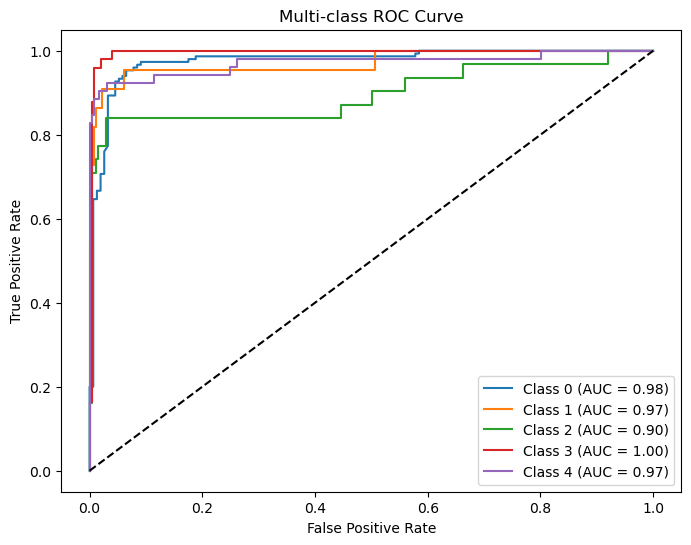

In [10]:
from sklearn.model_selection import train_test_split

num_samples = embeddings.shape[0]
embedding_dim = embeddings.shape[1]
num_classes = 5

train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(
    embeddings, labels, test_size=0.1, random_state=42, shuffle=True, stratify=labels
)

# 7. 創建 PyTorch Dataset & DataLoader
train_dataset = EmbeddingDataset(train_embeddings, train_labels)
test_dataset = EmbeddingDataset(test_embeddings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 8. 初始化並訓練模型
model = Classifier(embedding_dim, num_classes)
trained_model = train_model(train_loader, model)

# 9. 測試模型
labels, predictions_supervise = evaluate_model(test_loader, trained_model, num_classes, threshold=0.4, average=None)


In [12]:
import pandas as pd
df = pd.read_csv('result_on_NLM.csv')
df

,Unnamed: 0,True Label,Predicted_average
0,0,methods,methods
1,1,results,results
2,2,objective,objective
3,3,conclusions,conclusions
4,4,methods,results
...,...,...,...
299,299,objective,objective
300,300,conclusions,conclusions
301,301,objective,objective
302,302,background,background


In [13]:
df['Predicted_supervised'] = [mapping[i] for i in predictions_supervise]
df

,Unnamed: 0,True Label,Predicted_average,Predicted_supervised
0,0,methods,methods,methods
1,1,results,results,results
2,2,objective,objective,objective
3,3,conclusions,conclusions,conclusions
4,4,methods,results,results
...,...,...,...,...
299,299,objective,objective,objective
300,300,conclusions,conclusions,conclusions
301,301,objective,objective,objective
302,302,background,background,background


In [14]:
df = df.drop(columns=['Unnamed: 0'])

In [15]:
df

,True Label,Predicted_average,Predicted_supervised
0,methods,methods,methods
1,results,results,results
2,objective,objective,objective
3,conclusions,conclusions,conclusions
4,methods,results,results
...,...,...,...
299,objective,objective,objective
300,conclusions,conclusions,conclusions
301,objective,objective,objective
302,background,background,background


In [16]:
df.to_csv('result_on_NLM.csv')

In [78]:
torch.save(model, "classsifer_model/classifier_model_lower_test.pth")

## val

In [ ]:
from collections import defaultdict
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
import pandas

fine_tuned_model = SentenceTransformer("models/fine_tuned_sentence_bert_model_ContrastiveLoss_val_lower")

# 測試新模型
embeddings = fine_tuned_model.encode(sentences)


epoch 0:


100%|██████████| 76/76 [00:00<00:00, 814.48it/s]


Epoch 1/10, Loss: 55.2972
epoch 1:


100%|██████████| 76/76 [00:00<00:00, 838.08it/s]


Epoch 2/10, Loss: 4.6147
epoch 2:


100%|██████████| 76/76 [00:00<00:00, 837.56it/s]


Epoch 3/10, Loss: 1.0344
epoch 3:


100%|██████████| 76/76 [00:00<00:00, 828.90it/s]


Epoch 4/10, Loss: 0.4986
epoch 4:


100%|██████████| 76/76 [00:00<00:00, 840.69it/s]


Epoch 5/10, Loss: 0.3007
epoch 5:


100%|██████████| 76/76 [00:00<00:00, 839.29it/s]


Epoch 6/10, Loss: 0.2035
epoch 6:


100%|██████████| 76/76 [00:00<00:00, 838.45it/s]


Epoch 7/10, Loss: 0.1476
epoch 7:


100%|██████████| 76/76 [00:00<00:00, 839.50it/s]


Epoch 8/10, Loss: 0.1122
epoch 8:


100%|██████████| 76/76 [00:00<00:00, 832.61it/s]


Epoch 9/10, Loss: 0.0884
epoch 9:


100%|██████████| 76/76 [00:00<00:00, 812.90it/s]


Epoch 10/10, Loss: 0.0716
Precision: 0.9441
Recall: 0.9441
F1-score: 0.9441
Accuracy: 0.9441


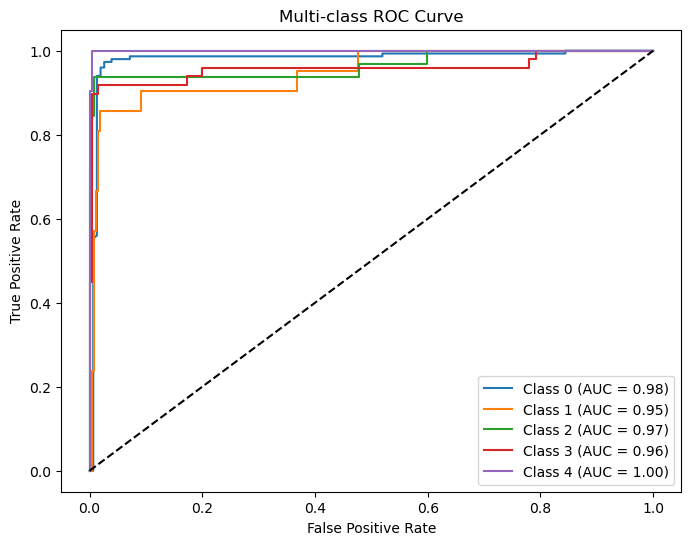

(0.944078947368421, 0.944078947368421, 0.944078947368421, 0.944078947368421)

In [ ]:
from sklearn.model_selection import train_test_split

num_samples = embeddings.shape[0]
embedding_dim = embeddings.shape[1]
num_classes = 5
threshold = 0.4

train_val_embeddings, test_embeddings, train_val_labels, test_labels = train_test_split(
    embeddings, labels, test_size=0.1, random_state=42, shuffle=True, stratify=labels
)

train_embeddings, val_embeddings, train_labels, val_labels = train_test_split(
    train_val_embeddings, train_val_labels, test_size=1/9, random_state=42, shuffle=True, stratify=train_val_labels
)

# 7. 創建 PyTorch Dataset & DataLoader
train_dataset = EmbeddingDataset(train_embeddings, train_labels)
val_dataset = EmbeddingDataset(val_embeddings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# 8. 初始化並訓練模型
model = Classifier(embedding_dim, num_classes)
trained_model = train_model(train_loader, model)

# 9. 測試模型
evaluate_model(val_loader, trained_model, num_classes, threshold, 'micro')


## Save whole

In [ ]:
from collections import defaultdict
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
import pandas

fine_tuned_model = SentenceTransformer("models/fine_tuned_sentence_bert_model_ContrastiveLoss_lower")

# 測試新模型
embeddings = fine_tuned_model.encode(sentences)


In [ ]:
fine_tuned_model = SentenceTransformer("models/fine_tuned_sentence_bert_model_ContrastiveLoss_lower")
# 測試新模型
embeddings = fine_tuned_model.encode(sentences)


epoch 0:


100%|██████████| 95/95 [00:00<00:00, 828.10it/s]


Epoch 1/10, Loss: 65.1999
epoch 1:


100%|██████████| 95/95 [00:00<00:00, 867.83it/s]


Epoch 2/10, Loss: 4.8169
epoch 2:


100%|██████████| 95/95 [00:00<00:00, 826.35it/s]


Epoch 3/10, Loss: 1.0642
epoch 3:


100%|██████████| 95/95 [00:00<00:00, 782.47it/s]


Epoch 4/10, Loss: 0.4978
epoch 4:


100%|██████████| 95/95 [00:00<00:00, 782.91it/s]


Epoch 5/10, Loss: 0.2963
epoch 5:


100%|██████████| 95/95 [00:00<00:00, 785.22it/s]


Epoch 6/10, Loss: 0.1984
epoch 6:


100%|██████████| 95/95 [00:00<00:00, 777.50it/s]


Epoch 7/10, Loss: 0.1429
epoch 7:


100%|██████████| 95/95 [00:00<00:00, 747.42it/s]


Epoch 8/10, Loss: 0.1080
epoch 8:


100%|██████████| 95/95 [00:00<00:00, 727.13it/s]


Epoch 9/10, Loss: 0.0847
epoch 9:


100%|██████████| 95/95 [00:00<00:00, 754.22it/s]

Epoch 10/10, Loss: 0.0681


In [ ]:

dataset = EmbeddingDataset(embeddings, labels)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Classifier(embedding_dim, num_classes)
trained_model = train_model(loader, model)

torch.save(model, "classifier_model_lower.pth")  # 或者用 .pt
